In [64]:
import networkx as nx
import numpy as np
import pandas as pd

from scipy import stats
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/ecoli_ppi_Hu_etal_2009.txt", header=None,names=["source", "target"], sep=" ")

In [3]:
g = nx.from_pandas_edgelist(df)
Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
g = g.subgraph(Gcc[0])


In [44]:
degree = nx.degree_centrality(g)
eigen = nx.eigenvector_centrality_numpy(g)
page = nx.pagerank_numpy(g)
closen = nx.closeness_centrality(g)
between = nx.betweenness_centrality(g, normalized=True)
subgraph = nx.subgraph_centrality(g)

In [45]:
nprop = pd.DataFrame([degree, eigen, page, closen, between, subgraph]).T
nprop.columns = ["degree", "eigen", "page", "closen", "between", "subgraph"]

In [46]:
ess = pd.read_csv("../data/ecoli_proteins_essentiality_Baba2006MSB.txt", sep=" ")

In [47]:
df = pd.merge(ess, nprop, left_on="gene", right_index=True)
df = df[df["essential"] != 'u'].reset_index()

In [48]:
df.head()

,index,gene,essential,degree,eigen,page,closen,between,subgraph
0,1,b0002,N,0.001196,0.000612,0.000269,0.240957,0.000036,4.138384e+09
1,3,b0004,N,0.003589,0.004852,0.000489,0.271252,0.000678,2.601425e+11
2,7,b0008,N,0.006579,0.006616,0.000745,0.273784,0.000387,4.836786e+11
3,8,b0009,N,0.000598,0.000559,0.000148,0.236861,0.000000,3.457115e+09
4,14,b0015,N,0.034689,0.073207,0.003605,0.346026,0.020723,5.921484e+13


<AxesSubplot:xlabel='essential', ylabel='subgraph'>

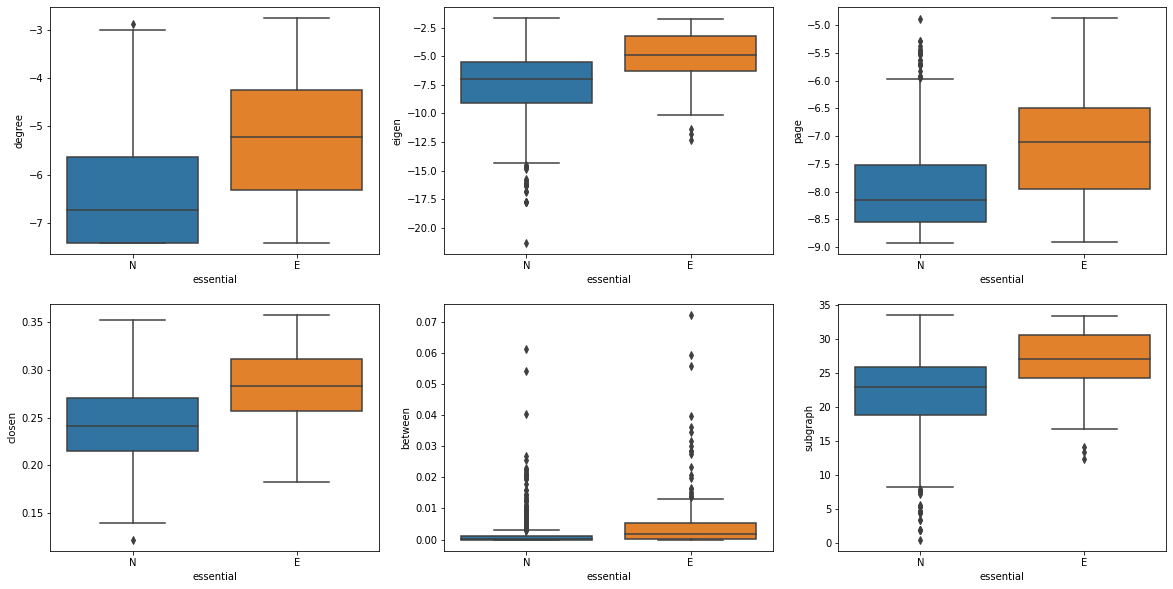

In [49]:
fig, (ax) = plt.subplots(2, 3, figsize=(20, 10))

sns.boxplot(y=np.log(df["degree"]), x=df["essential"], ax=ax[0][0])
sns.boxplot(y=np.log(df["eigen"]), x=df["essential"], ax=ax[0][1])
sns.boxplot(y=np.log(df["page"]), x=df["essential"], ax=ax[0][2])
sns.boxplot(y=df["closen"], x=df["essential"], ax=ax[1][0])
sns.boxplot(y=np.log(df["between"]+1), x=df["essential"], ax=ax[1][1])
sns.boxplot(y=np.log(df["subgraph"]), x=df["essential"], ax=ax[1][2])


## 必須タンパク質と非必須タンパク質の中心性指標の差の検定

In [50]:
ess_nprop = df[df["essential"] == "E"]
noness_nprop = df[df["essential"] != "E"]

## mannwhitneyu検定

In [58]:
for col in ["degree", "eigen", "page", "closen", "between", "subgraph"]:
    print(f'{col}中心性（degree centrality）中央値　必須：{ess_nprop[col].median()}, 非必須: {noness_nprop[col].median()}')
    print(stats.mannwhitneyu(ess_nprop[col], noness_nprop[col]))
    print()

degree中心性（degree centrality）中央値　必須：0.005382775119617224, 非必須: 0.0011961722488038277
MannwhitneyuResult(statistic=57741.0, pvalue=1.2203453488118735e-30)

eigen中心性（degree centrality）中央値　必須：0.007403474080862463, 非必須: 0.0008999915152067401
MannwhitneyuResult(statistic=55829.0, pvalue=5.208045052537086e-31)

page中心性（degree centrality）中央値　必須：0.0008231836754910133, 非必須: 0.0002878847235706673
MannwhitneyuResult(statistic=61240.0, pvalue=6.41819012068797e-26)

closen中心性（degree centrality）中央値　必須：0.2831260639812404, 非必須: 0.2417932031814895
MannwhitneyuResult(statistic=56417.5, pvalue=1.9662941713802027e-30)

between中心性（degree centrality）中央値　必須：0.0017566281319038141, 非必須: 3.418958616829966e-05
MannwhitneyuResult(statistic=63157.0, pvalue=1.4314529200154875e-25)

subgraph中心性（degree centrality）中央値　必須：605614953888.1516, 非必須: 8949452569.136282
MannwhitneyuResult(statistic=55827.0, pvalue=5.183927558391825e-31)



## 単一の中心性指標を用いて必須タンパク質を判別する
### 前準備

In [61]:
ess_score = [1 if x == "E" else 0 for x in df["essential"].values]

## ROCカーブのプロット

/Users/koga/.pyenv/versions/3.8.9/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/koga/.pyenv/versions/3.8.9/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/koga/.pyenv/versions/3.8.9/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

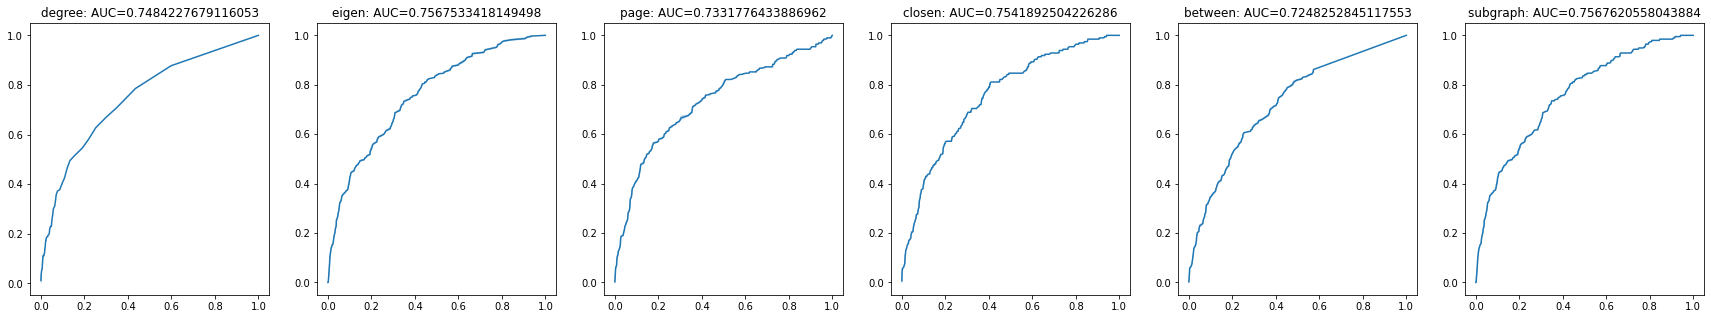

In [107]:
cols = ["degree", "eigen", "page", "closen", "between", "subgraph"]
fig, (ax) = plt.subplots(1, 6, figsize=(30, 5))

for i in range(len(cols)):
    col = cols[i]
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(ess_score, df[col].values)
    sns.lineplot(fpr, tpr, ax=ax[i%len(cols)])
    ax[i%len(cols)].set_title(f"{col}: AUC={sklearn.metrics.roc_auc_score(ess_score, df[col].values)}")
    
